In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

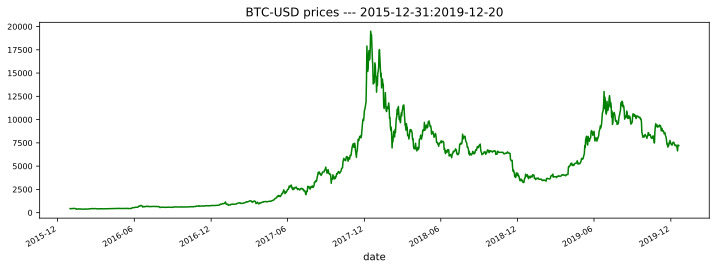

In [4]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-20', 
                  freq='daily', 
                  path='data/BTC.csv')

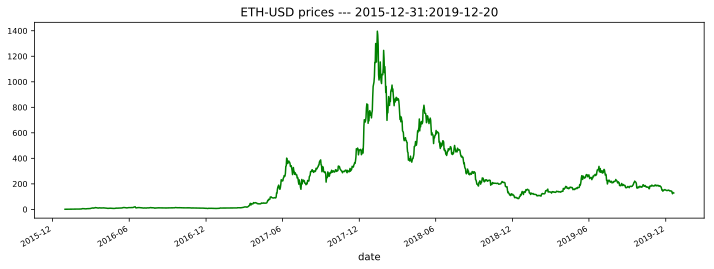

In [5]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-20', 
                  freq='daily', 
                  path='data/ETH.csv')

In [6]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [7]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                   open        close
date                                
2019-12-16  6932.480469  6932.480469
2019-12-17  6640.515137  6640.515137
2019-12-18  7276.802734  7276.802734
2019-12-19  7202.844238  7202.844238
2019-12-20  7205.154785  7205.154785
                  open       close
date                              
2019-12-16  133.614029  133.614029
2019-12-17  122.603889  122.603889
2019-12-18  133.092194  133.092194
2019-12-19  129.321136  129.321136
2019-12-20  128.496185  128.496185


In [8]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1451 (major_axis) x 2 (minor_axis)
Items axis: BTC to ETH
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-20 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [9]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,BTC,ETH
BTC,1.000000,0.760964
ETH,0.760964,1.000000


# Построение границы эффективности

###  Задаем стартовые параметры

In [10]:
# set the number of combinations for imaginary portfolios
num_portfolios = 500
COMMISSION = 0.0007
REBALANCE_PERIOD = 21
CASH = 0.15

### Определяем стартовые переменные

In [11]:
num_assets = len(TIKERS)

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

#set random seed for reproduction's sake
np.random.seed(101)

In [12]:
# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in tqdm(range(num_portfolios)):
    weights = np.random.random(num_assets)     # добавил "+1"  (учитывем еще и cash)
    weights /= np.sum(weights)/(1-CASH)
    WEIGHTS = weights
    
    def initialize(context):
    
        context.set_commission(commission.PerDollar(cost=COMMISSION))

        set_benchmark(symbol('BTC'))

        context.tikers = TIKERS
        context.assets = [context.symbol(symbol) for symbol in context.tikers]

        context.weights = WEIGHTS
        context.n_assets = len(context.assets)

        context.window = 1

        context.rebalance_period = REBALANCE_PERIOD
        context.time = 0
    
    def handle_data(context, data):

        # Закупка и ребаллансировка
        if context.time == 0 or (context.time % context.rebalance_period == 0):


            # submit orders
            for i, asset in enumerate(context.assets):
                order_target_percent(asset, context.weights[i])


        context.time += 1
    
    perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                                  end=datetime(2019, 12, 20, 0, 0, 0, 0, pytz.utc),
                                  initialize=initialize,
                                  capital_base=100000000,
                                  handle_data=handle_data,
                                  data=panel)

    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
    port_returns.append(qf.get_performance_summary(returns).annualized_returns)
    port_volatility.append(qf.get_performance_summary(returns).annual_volatility)
    stock_weights.append(WEIGHTS)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [16:32<00:00,  1.99s/it]


# Визуализация результатов

In [13]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [14]:
df.head()

,Returns,Volatility,Sharpe Ratio,BTC Weight,ETH Weight
0,2.008738,0.788531,1.782589,0.403783,0.446217
1,2.279916,0.990241,1.671544,0.121018,0.728982
2,2.039511,0.801631,1.778071,0.383423,0.466577
3,2.225427,0.917345,1.717351,0.217329,0.632671
4,1.444274,0.652875,1.695171,0.672873,0.177127


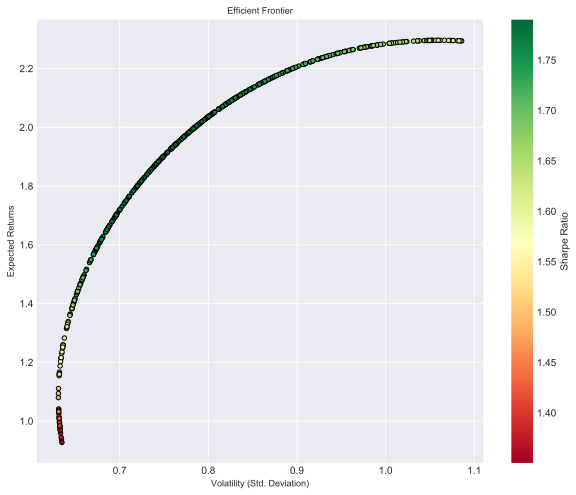

In [15]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
#fig, ax = plt.subplots()
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)', fontsize = 9)
plt.ylabel('Expected Returns', fontsize = 9)
plt.title('Efficient Frontier', fontsize = 9)
plt.show()

# Оптимальное соотношение активов

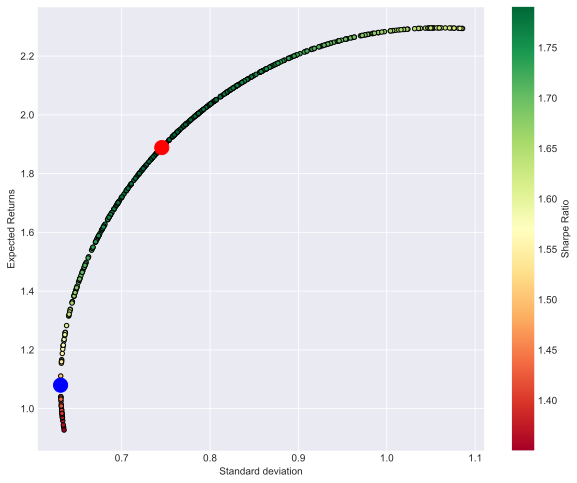

In [16]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='o', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='o', s=200 )
plt.xlabel('Standard deviation')
plt.ylabel('Expected Returns')
#plt.title('Efficient Frontier')
plt.show()

In [17]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)

                   258
Returns       1.079745
Volatility    0.630879
Sharpe Ratio  1.475997
BTC Weight    0.800393
ETH Weight    0.049607
                   173
Returns       1.888499
Volatility    0.745399
Sharpe Ratio  1.790151
BTC Weight    0.474506
ETH Weight    0.375494
